#### task:

given gene expression (RNA), predict surface protein levels.

- train/test_cite_inputs.h5: Rows corresponding to cells and columns corresponding to genes given by {gene_name}_{gene_ensemble-ids}\
 - have 22085 genes
 - from these: 84 are handselected and hstacked to the right
 - ... and on the remaining 22001 genes, TruncatedSVD is applied -> 128 svd components instead -> hstacked to the left
- train_cite_targets.h5: Surface protein levels for the same cells
 - 140 proteins, e.g. CD36

previous notebooks: compute shap values 
- on svd components + handselected: get shap values of shape (140, n_samples, n_svd_components+84)
- backpropagated attributions to all genes: get attr_all_22085_genes of shape (140, n_samples, 22085)

plotting.ipynb: compare plots for different proteins
now: 
- quantify results in plots
- kl divergence as new metric to order feature importance by

In [1]:
%%capture output
!pip install shap
!pip install anndata
!pip install ipywidgets
!pip install --upgrade jupyter
!pip install IProgress

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import pandas as pd
import os

import shap

import anndata as ad
import scipy
# import scipy.special as sp
import scanpy as sc

from scipy import stats


In [4]:
os.chdir('../..')

In [5]:
lrz_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/'
index_path = lrz_path + 'open-problems-multimodal-3rd-solution/input/preprocess/cite/'
train_column = np.load(index_path + "train_cite_raw_inputs_idxcol.npz", allow_pickle=True)["columns"]

In [6]:
def get_top_features(shap_values, xtest, top_n):
    shap_sum = np.abs(shap_values).sum(axis=0)
    top_features_indices = np.argsort(shap_sum)[::-1][:top_n]  # Get the indices of the top n features
    top_feature_names_shap = xtest.var_names[top_features_indices]
    return top_feature_names_shap

In [7]:
def get_common_elements(attr, xtest, top_features_considered, min_percentage):
    element_counts = {}

    for i in range(140):
        for elt in get_top_features(attr[i], xtest, top_features_considered):
            element_counts[elt] = element_counts.get(elt, 0) + 1

    # Get the elements that appear in at least min_percentage of the lists
    common_elements = {element for element, count in element_counts.items() if count / 140 >= min_percentage}
    return common_elements

In [10]:
def get_gene_name(last_chars):
    return [element for element in train_column if element.split('_')[1] == last_chars]

### attr_all_22085_genes of model 16

In [9]:
proteins = np.load('4.model/pred/proteins.npy', allow_pickle=True)
def get_protein_idx(protein):
    return np.where(proteins == protein)[0][0]
proteins

array(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c',
       'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7', 'CD105', 'CD49f', 'CD194',
       'CD4', 'CD44', 'CD14', 'CD16', 'CD25', 'CD45RO', 'CD279', 'TIGIT',
       'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b', 'CD20',
       'CD335', 'CD31', 'Podoplanin', 'CD146', 'IgM', 'CD5', 'CD195',
       'CD32', 'CD196', 'CD185', 'CD103', 'CD69', 'CD62L', 'CD161',
       'CD152', 'CD223', 'KLRG1', 'CD27', 'CD107a', 'CD95', 'CD134',
       'HLA-DR', 'CD1c', 'CD11b', 'CD64', 'CD141', 'CD1d', 'CD314',
       'CD35', 'CD57', 'CD272', 'CD278', 'CD58', 'CD39', 'CX3CR1', 'CD24',
       'CD21', 'CD11a', 'CD79b', 'CD244', 'CD169', 'integrinB7', 'CD268',
       'CD42b', 'CD54', 'CD62P', 'CD119', 'TCR', 'Rat-IgG1', 'Rat-IgG2a',
       'CD192', 'CD122', 'FceRIa', 'CD41', 'CD137', 'CD163', 'CD83',
       'CD124', 'CD13', 'CD2', 'CD226', 'CD29', 'CD303', 'CD49b', 'C

In [11]:
xtest_16 = ad.read_h5ad('4.model/pred/private_test_input_128_svd_50_samples.h5ad')
private_test_input_raw = pd.read_pickle('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data/20220830_citeseq_rna_count_test_input_private_raw.pkl')
sample_cells = np.array(xtest_16.obs_names)
xtest_all_genes = private_test_input_raw.loc[sample_cells]

In [12]:
attr_all_22085_genes_16 = pd.read_pickle(lrz_path + 'large_preprocessed_files/attr_all_genes/attr_all_22085_genes_16_50_samples_p_ct_distr.pkl')
for i in range(len(attr_all_22085_genes_16)):
    attr_all_22085_genes_16[i] = attr_all_22085_genes_16[i].reindex(columns=train_column)

In [13]:
# top_20 = get_top_features(attr_all_22085_genes_16[0], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20)
# top_20

In [14]:
# get_top_features(attr_all_22085_genes_16[2], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20)

In [15]:
# get_top_features(attr_all_22085_genes_16[3], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20)

In [16]:
# top attributing genes across all targets
# get_common_elements(attr_all_22085_genes_16, ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20, 0.75)

### model 17:

In [17]:
xtest_17 = ad.read_h5ad('4.model/pred/private_test_input_64_svd_50_samples.h5ad')
attr_all_22085_genes_17 = pd.read_pickle(lrz_path + 'large_preprocessed_files/attr_all_genes/attr_all_22085_genes_17_50_samples_p_ct_distr.pkl')
for i in range(len(attr_all_22085_genes_17)):
    attr_all_22085_genes_17[i] = attr_all_22085_genes_17[i].reindex(columns=train_column)

### quantify results from plotting.ipynb: compare gene attr distr to avg distr

spearman correlation and kurtosis variance metric did not work

In [26]:
def plot_distr_avg_gene(model_number, protein, gene, show=True):
    ''' plot avg distribution of top columns along with distribution of a specific gene for comparison
    model_number: 16 or 17
    show=True: show plot for specific gene
    show=False: don't show plot, instead print kl divergence for top 20 genes '''
    
    # get columns of top attributing genes in attribution dataframe 
    if model_number==16:
        top = get_top_features(attr_all_22085_genes_16[get_protein_idx(protein)], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20)
        if get_gene_name(gene)[0] not in top:  # if specific gene not among the top features but should still be plotted
            top = top.append(pd.Index(get_gene_name(gene)))
#         df = attr_all_22085_genes_16[get_protein_idx(protein)][top].copy()
        df = attr_all_22085_genes_16[get_protein_idx(protein)].sample(20, axis=1).copy()
    if model_number==17:
        top = get_top_features(attr_all_22085_genes_17[get_protein_idx(protein)], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20)
        if get_gene_name(gene)[0] not in top:  # if specific gene not among the top features but should still be plotted
            top = top.append(pd.Index(get_gene_name(gene)))
#         df = attr_all_22085_genes_17[get_protein_idx(protein)][top].copy()
        df = attr_all_22085_genes_17[get_protein_idx(protein)].sample(20, axis=1).copy()
    
    # Initialize an array to store the sum of histograms
    hist_sum = np.zeros(40)  # 40 bins
    # Calculate the histogram for each column and sum them
    for col in df.columns:
        hist, edges = np.histogram(df[col], bins=40, range=(df.min().min(), df.max().max()), density=True)
        hist_sum += hist

    # Divide by the number of columns to average hist_sum
    avg_hist = hist_sum /len(df.columns)
    
    
    if show:
        # Plot the average histogram
        plt.bar(edges[:-1], avg_hist, width=(edges[1]-edges[0]), label='Avg')
        
        
        # Plot histogram for single gene to be compared
        hist, edges = np.histogram(df[get_gene_name(gene)], bins=40, range=(df.min().min(), df.max().max()), density=True)
        # Plot the histogram
        plt.bar(edges[:-1], hist, width=(edges[1]-edges[0]), color='orange', alpha=0.7, label=gene)
    
        # print kl divergence between both distributions
        # add 1e-10 to avoid dividing by 0
        print(np.sum(scipy.special.kl_div(avg_hist+1e-10, hist+1e-10)))
        plt.xlabel('Attribution value')
        plt.ylabel('Normalized frequency')
        plt.title(f'Prediction of {protein}: Average distribution and distribution of {get_gene_name(gene)[0]}')
        plt.legend(loc='upper right')
        plt.show()
    else:
        # plot top attributing genes by kl divergence:
        kl_div_list = []
        for top_gene in top:
            # compute hist for current gene:
            hist, _ = np.histogram(df[top_gene], bins=40, range=(df.min().min(), df.max().max()), density=True)
            
            # append kl divergence between the current gene distr and the avg distr to the list
            kl_div_list.append(np.sum(scipy.special.kl_div(avg_hist+1e-10, hist+1e-10)))
        
        # sort desc by kl divergence
        sorted_genes, sorted_values = zip(*sorted(zip(top, kl_div_list), key=lambda x: x[1]))

        # Create a bar chart
        plt.figure(figsize=(10, 6))
        plt.barh(sorted_genes, sorted_values) #, color='skyblue')
        plt.xlabel('KL Divergence Value')
        plt.ylabel('Top Genes')
        plt.title(f'Prediction of {protein}: Top attributing genes by KL divergence value')
        plt.tight_layout()
        plt.show()

In [27]:
plot_distr_avg_gene(17, 'CD86', 'CD86', show=False)   # decreasing kl divergence for decreasingly important genes

X converted to numpy array with dtype float64


KeyError: 'ENSG00000117091_CD48'

X converted to numpy array with dtype float64


2494.8408230898094


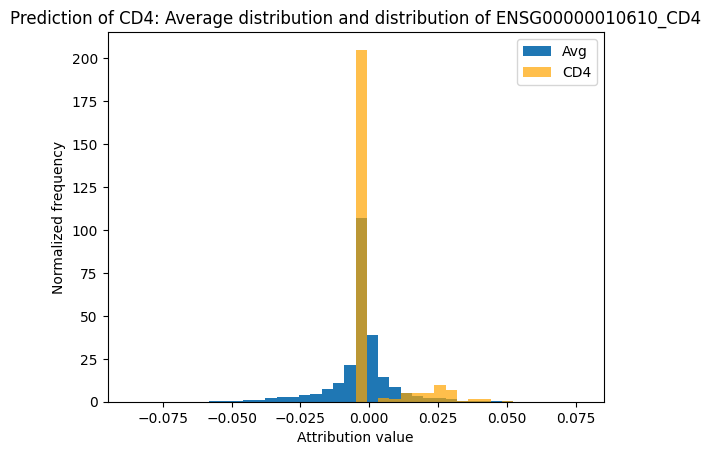

In [22]:
plot_distr_avg_gene(16, 'CD4', 'CD4')   # decreasing kl divergence for decreasingly important genes

X converted to numpy array with dtype float64


125.2772928188259


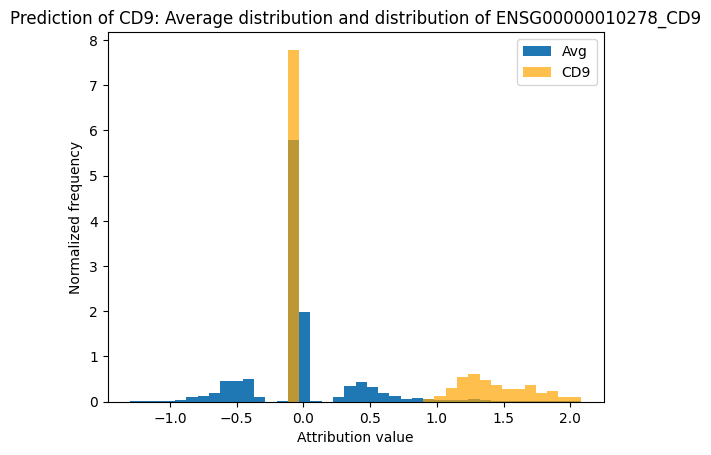

In [24]:
plot_distr_avg_gene(17, 'CD9', 'CD9') 

### compute mean per cell type

In [ ]:
# moved computing the mean to plotting.ipynb
# TODO move min/max as well? Delete from here?
def mean_per_cell_type(attr_all_genes, xtest, n_top, stat):
    ''' stat: pass mean, min, max, median '''
    top_feature_names_shap = get_top_features(attr_all_genes, xtest, n_top)
    # create df with shap values of top n features + cell type    
    shap_cell_types = {}
    # Add 'Cell Type' column
    shap_cell_types['Cell Type'] = xtest.obs['cell_type']
    # Add attribution values of top n features
    for feature in top_feature_names_shap:
        column_values = np.array(attr_all_genes)[:, xtest.var_names.get_loc(feature)]
        shap_cell_types[feature] = column_values

    # Create DataFrame
    shap_cell_types = pd.DataFrame(shap_cell_types)
    
    if stat == 'mean':
        mean_per_ct = shap_cell_types.groupby('Cell Type').apply(lambda x: x.abs().mean())
        mean_per_ct.reset_index(inplace=True)
        # Calculate the mean across all rows (excluding the 'cell type' column)
        overall_mean = shap_cell_types.drop('Cell Type', axis=1).abs().mean()
        # Add the overall mean as a new row to the DataFrame
        mean_per_ct.loc[len(mean_per_ct)] = ['Overall'] + overall_mean.tolist()
    elif stat == 'min':
        mean_per_ct = shap_cell_types.groupby('Cell Type').min()
        mean_per_ct.reset_index(inplace=True)
        # Calculate the mean across all rows (excluding the 'cell type' column)
        overall_mean = shap_cell_types.drop('Cell Type', axis=1).min()
        # Add the overall mean as a new row to the DataFrame
        mean_per_ct.loc[len(mean_per_ct)] = ['Overall'] + overall_mean.tolist()
    elif stat == 'max':
        mean_per_ct = shap_cell_types.groupby('Cell Type').max()
        mean_per_ct.reset_index(inplace=True)
        # Calculate the mean across all rows (excluding the 'cell type' column)
        overall_mean = shap_cell_types.drop('Cell Type', axis=1).max()
        # Add the overall mean as a new row to the DataFrame
        mean_per_ct.loc[len(mean_per_ct)] = ['Overall'] + overall_mean.tolist()
    elif stat == 'median':
        mean_per_ct = shap_cell_types.groupby('Cell Type').median()
        mean_per_ct.reset_index(inplace=True)
        # Calculate the mean across all rows (excluding the 'cell type' column)
        overall_mean = shap_cell_types.drop('Cell Type', axis=1).median()
        # Add the overall mean as a new row to the DataFrame
        mean_per_ct.loc[len(mean_per_ct)] = ['Overall'] + overall_mean.tolist()
    
    return mean_per_ct

In [ ]:
mean_per_cell_type(attr_all_22085_genes_16[121], ad.AnnData(xtest_all_genes, obs=xtest_16.obs, dtype=xtest_all_genes.dtypes), 20, 'mean')

In [ ]:
mean_per_cell_type(attr_all_22085_genes_17[121], ad.AnnData(xtest_all_genes, obs=xtest_16.obs, dtype=xtest_all_genes.dtypes), 20, 'mean')